In [20]:
import pandas as pd
import numpy as np
from numpy import log, sqrt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from matplotlib import pyplot
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math

pd.options.display.float_format = '{:.5f}'.format

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

### Model Results
The graph and the model metrics show model 2 is not a great fit but much better than model 1

## Retail Time Series Model Example: Prophet Models

In [21]:
# Read in retain data
train = pd.read_csv('Data/train.csv')
train.head()

/Users/kelsey.huntzberry/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [22]:
# Printing minimum and maximum date in the data set to inform size of the validation data set
print("max date: " + str(train.Date.max()))
print("min date: " + str(train.Date.min()))

max date: 2015-07-31
min date: 2013-01-01


In [23]:
# Aggregate all sales to a daily level across stores
ts_data_temp = train.groupby('Date')['Sales'].sum().reset_index()
ts_data_temp.head()

,Date,Sales
0,2013-01-01,97235
1,2013-01-02,6949829
2,2013-01-03,6347820
3,2013-01-04,6638954
4,2013-01-05,5951593


In [24]:
ts_data_temp['Sales'].mean()

6234798.962845011

In [25]:
# Confirming date is in date/time format
ts_data_temp.dtypes

Date     object
Sales     int64
dtype: object

In [26]:
# Convert to date/time format
ts_data_temp['Date'] = pd.to_datetime(ts_data_temp['Date'])
ts_data_temp.rename(columns={'Date':'ds',
                        'Sales':'y'},inplace=True)
ts_data_temp.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [27]:
ts_data_temp.head()

,ds,y
0,2013-01-01,97235
1,2013-01-02,6949829
2,2013-01-03,6347820
3,2013-01-04,6638954
4,2013-01-05,5951593


In [28]:
# Split into a training and validation data set
ts_data = ts_data_temp.iloc[0:850, :]
test_sales = ts_data_temp.iloc[850:,:]

print("max date: " + str(ts_data.ds.max()))
print("min date: " + str(test_sales.min()))

max date: 2015-04-30 00:00:00
min date: ds    2015-05-01 00:00:00
y                  249207
dtype: object


In [29]:
# Find sales summary statistics
test_sales['y'].describe()

count         92.00000
mean     6617716.15217
std      3287024.40162
min       249207.00000
25%      6284784.50000
50%      6956487.50000
75%      8622252.75000
max     11916672.00000
Name: y, dtype: float64

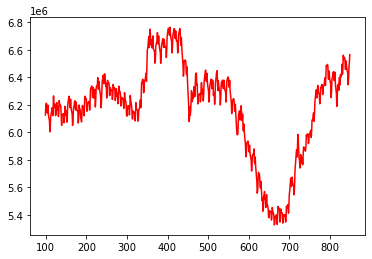

In [30]:
# Visualize a rolling average plot of sales data. Rolling average window is 100 days.
rolling = ts_data['y'].rolling(window=100)
rolling_mean = rolling.mean()
rolling_mean.plot(color='red')
pyplot.show()

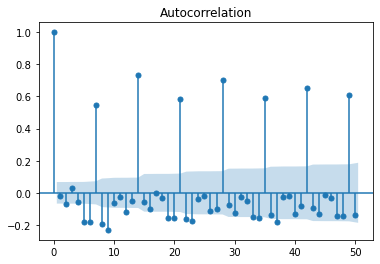

In [31]:
# Plot autocorrelation plots
plot_acf(ts_data['y'], lags=50)
pyplot.show()

#### The autocorrelation plot shows that there is seasonality in the data. ARIMA models will not work.

In [32]:
# Perform augmented Dickey-Fuller test to test for stationarity
result = adfuller(ts_data['y'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.605418
p-value: 0.000126
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


#### Dickey-Fuller test shows the data is stationary. However, with the seasonality in the data, we need to choose a model that accounts for that. We could use SARIMA but I will show Prophet models. These models give us additional information that is useful for retail models

## Plot Default Prophet Model

In [33]:
# Running Prophet models
m = Prophet()
# Fitting the model
m.fit(ts_data)
# Making a data frame of the size of 92 days, the length of our validation data set
future = m.make_future_dataframe(periods=92)
# Use fitted model to make the predictions
forecast = m.predict(future)

20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:52 - cmdstanpy - INFO - Chain [1] done processing


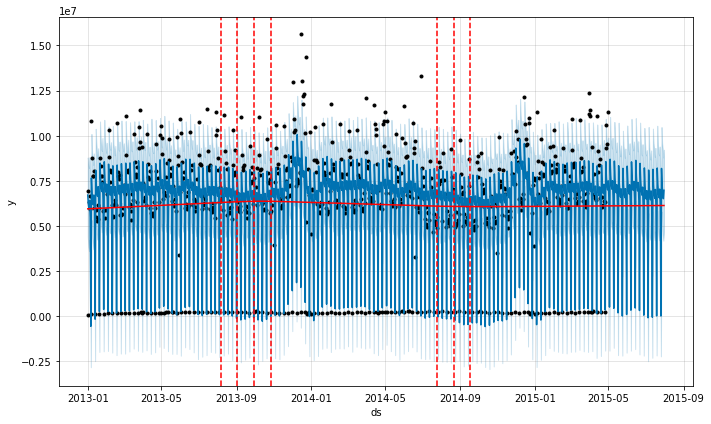

In [34]:
# Plot the time series data with changepoints and forecast
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

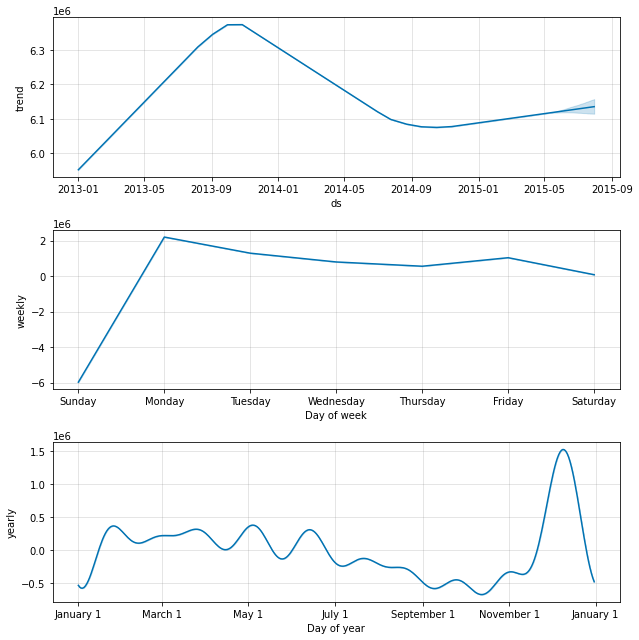

In [35]:
# Plot time series component charts
fig2 = m.plot_components(forecast)

### Model insights
- Strong increase in trend at the end of 2013
- Sales are strongest on Monday, Tuesday and Friday. Sunday sales are extremely low.
- Holiday sales are the highest, indicating we need to incorporate the holiday effect to the models
- The yearly seasonality was relatively stable outside of the holidays

### Plotting model changepoints

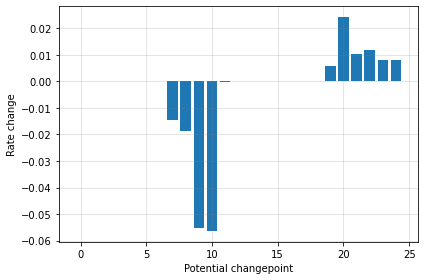

In [36]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

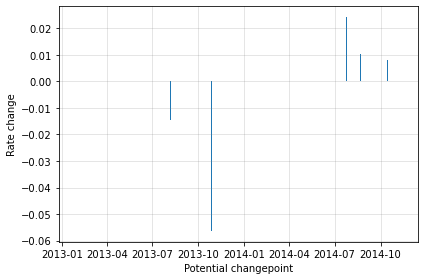

In [37]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [38]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,5951790.61060,4447246.17285,8797355.29596,5951790.61060,5951790.61060,765176.23231,765176.23231,765176.23231,1294285.04711,1294285.04711,1294285.04711,-529108.81479,-529108.81479,-529108.81479,0.00000,0.00000,0.00000,6716966.84291
1,2013-01-02,5953430.66357,3823844.65114,8491081.24801,5953430.66357,5953430.66357,242063.00200,242063.00200,242063.00200,799019.89070,799019.89070,799019.89070,-556956.88869,-556956.88869,-556956.88869,0.00000,0.00000,0.00000,6195493.66557
2,2013-01-03,5955070.71654,3625304.67512,8225525.63422,5955070.71654,5955070.71654,-12187.32905,-12187.32905,-12187.32905,558946.49089,558946.49089,558946.49089,-571133.81994,-571133.81994,-571133.81994,0.00000,0.00000,0.00000,5942883.38749
3,2013-01-04,5956710.76950,4253840.71931,8813938.72700,5956710.76950,5956710.76950,466984.89070,466984.89070,466984.89070,1039042.20495,1039042.20495,1039042.20495,-572057.31426,-572057.31426,-572057.31426,0.00000,0.00000,0.00000,6423695.66020
4,2013-01-05,5958350.82247,3175043.66622,7706421.85968,5958350.82247,5958350.82247,-479165.98997,-479165.98997,-479165.98997,81226.50487,81226.50487,81226.50487,-560392.49484,-560392.49484,-560392.49484,0.00000,0.00000,0.00000,5479184.83250


In [39]:
# Storing predictions for final model evaluation
predicted_sales = forecast[forecast['ds'] >= test_sales.ds.min()].reset_index()
test_sales = test_sales.reset_index()
test_sales['predictions_model1'] = predicted_sales['yhat']
test_sales.head()

,index,ds,y,predictions_model1
0,850,2015-05-01,264231,7500570.11486
1,851,2015-05-02,8764984,6558739.01726
2,852,2015-05-03,249207,512641.01662
3,853,2015-05-04,10995906,8698683.66068
4,854,2015-05-05,8778928,7790165.81288


<AxesSubplot:xlabel='ds'>

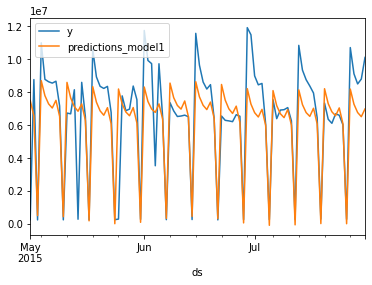

In [40]:
test_sales[['ds','y','predictions_model1']].plot(x='ds')

## Add Holidays to Prophet Model

In [41]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(ts_data)
future = m.make_future_dataframe(periods=92)
forecast = m.predict(future)

20:13:55 - cmdstanpy - INFO - Chain [1] start processing
20:13:56 - cmdstanpy - INFO - Chain [1] done processing


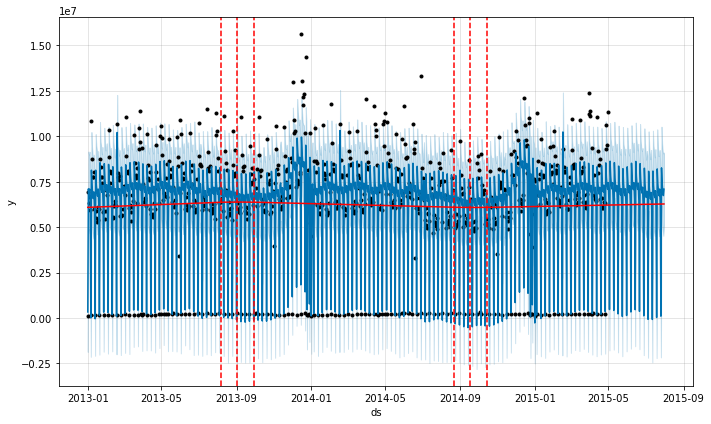

In [42]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

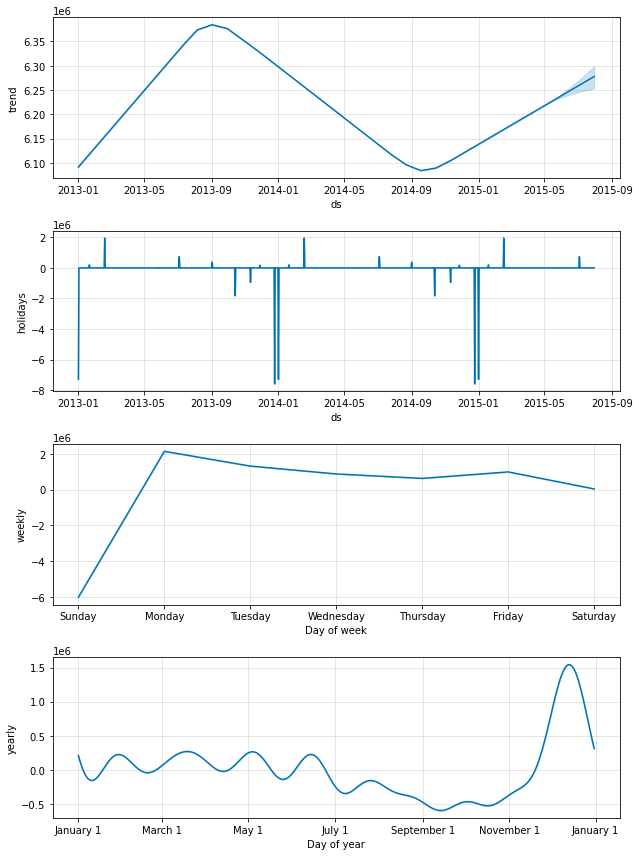

In [43]:
fig2 = m.plot_components(forecast)

### Christmas holiday effect is less dramatic than the previous model where we did not control for the holiday effect

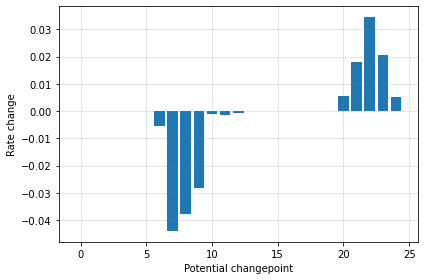

In [44]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

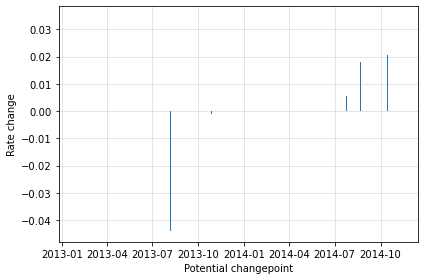

In [45]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [46]:
# Storing predictions for final model evaluation
predicted_sales = forecast[forecast['ds'] >= test_sales.ds.min()].reset_index()
test_sales = test_sales.reset_index()
test_sales['predictions_model2'] = predicted_sales['yhat']

<AxesSubplot:xlabel='ds'>

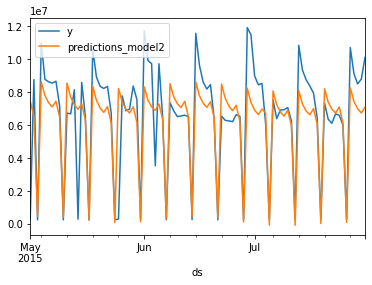

In [47]:
test_sales[['ds','y','predictions_model2']].plot(x='ds')

## Change Model to Multiplicative Since Seasonality Changes Over Time

In [48]:
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')
m.fit(ts_data)
future = m.make_future_dataframe(periods=92)
forecast = m.predict(future)

20:13:58 - cmdstanpy - INFO - Chain [1] start processing
20:13:59 - cmdstanpy - INFO - Chain [1] done processing


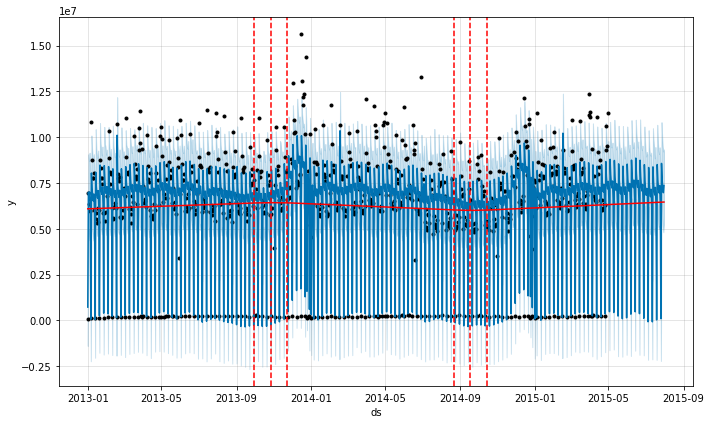

In [49]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

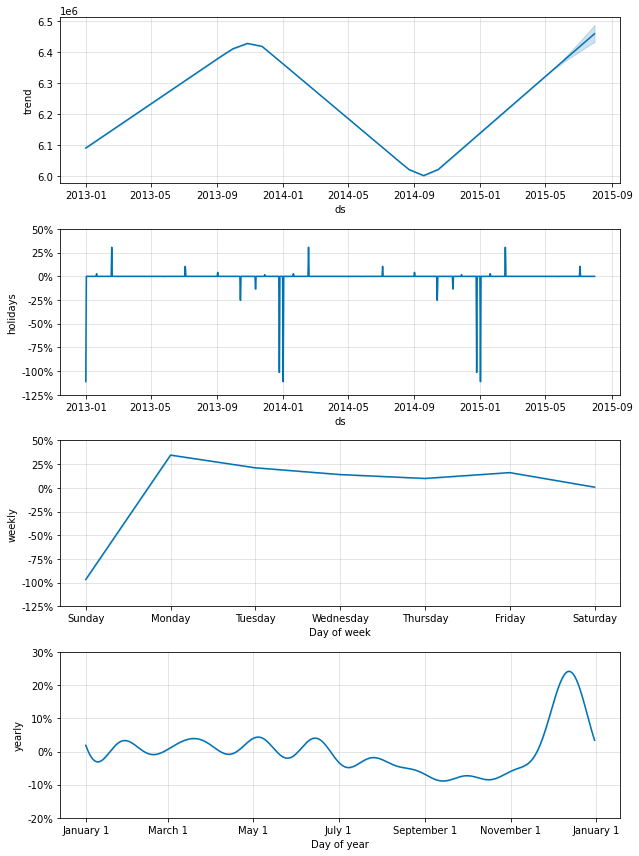

In [50]:
fig2 = m.plot_components(forecast)

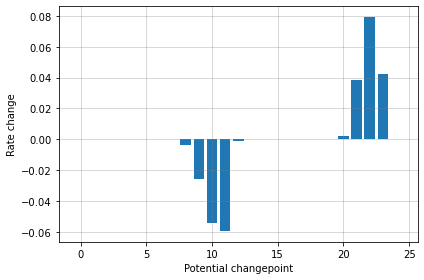

In [51]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.3)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

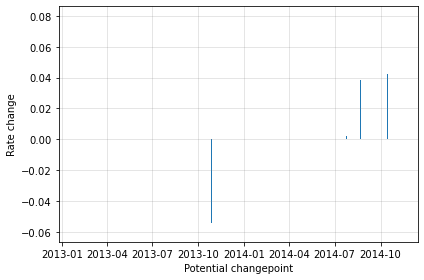

In [52]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [53]:
# Storing predictions for final model evaluation
predicted_sales = forecast[forecast['ds'] >= test_sales.ds.min()].reset_index()
test_sales['predictions_model3'] = predicted_sales['yhat']

<AxesSubplot:xlabel='ds'>

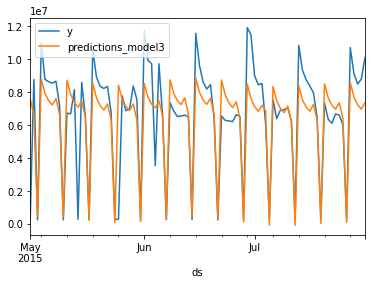

In [54]:
test_sales[['ds','y','predictions_model3']].plot(x='ds')

## Change Model to Have More Flexible Trend to Reduce Overfitting (higher changepoint_prior_scale)

In [55]:
m = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.2)
m.add_country_holidays(country_name='US')
m.fit(ts_data)
future = m.make_future_dataframe(periods=92)
forecast = m.predict(future)

20:14:01 - cmdstanpy - INFO - Chain [1] start processing
20:14:01 - cmdstanpy - INFO - Chain [1] done processing


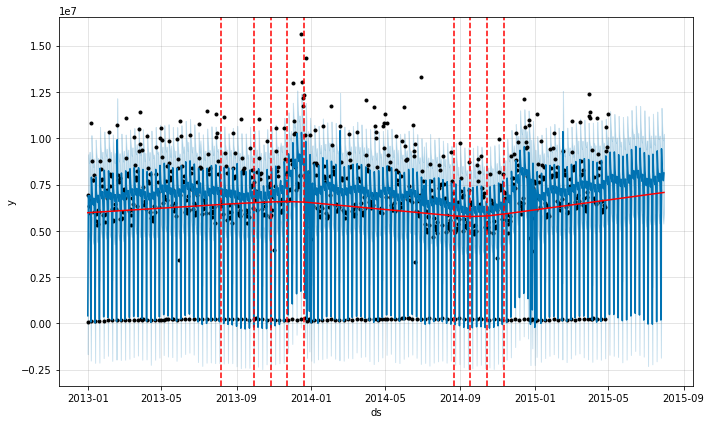

In [56]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

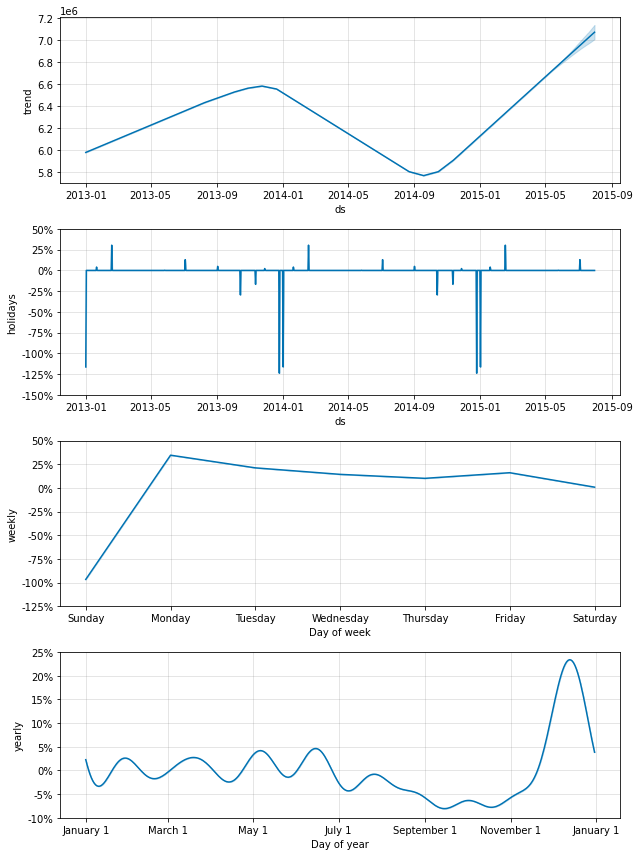

In [57]:
fig2 = m.plot_components(forecast)

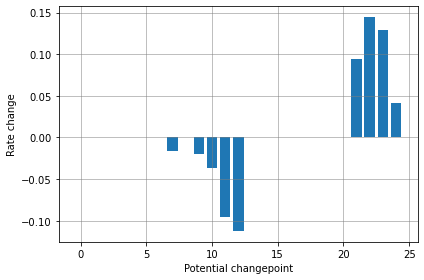

In [58]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.5)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

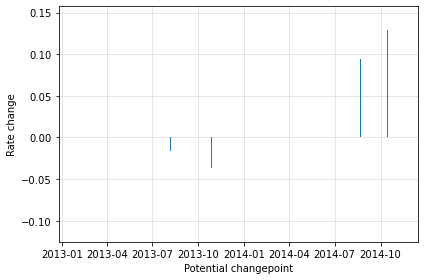

In [59]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [60]:
# Storing predictions for final model evaluation
predicted_sales = forecast[forecast['ds'] >= test_sales.ds.min()].reset_index()
test_sales['predictions_model4'] = predicted_sales['yhat']

<AxesSubplot:xlabel='ds'>

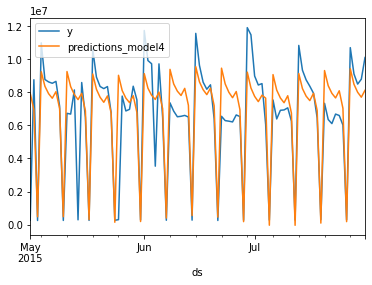

In [61]:
test_sales[['ds','y','predictions_model4']].plot(x='ds')

In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print('Default Prophet Model')
print('model1 mse is: ' + str(mean_squared_error(test_sales['y'], test_sales['predictions_model1'])))
print('model1 mae is: ' + str(mean_absolute_error(test_sales['y'], test_sales['predictions_model1'])))
print('model1 mape is: ' + str(mean_absolute_percentage_error(test_sales['y'], test_sales['predictions_model1'])))

print('Prophet Model with Holidays')
print('model2 mse is: ' + str(mean_squared_error(test_sales['y'], test_sales['predictions_model2'])))
print('model2 mae is: ' + str(mean_absolute_error(test_sales['y'], test_sales['predictions_model2'])))
print('model2 mape is: ' + str(mean_absolute_percentage_error(test_sales['y'], test_sales['predictions_model2'])))

print('Change Model to Multiplicative Seasonality')
print('model3 mse is: ' + str(mean_squared_error(test_sales['y'], test_sales['predictions_model3'])))
print('model3 mae is: ' + str(mean_absolute_error(test_sales['y'], test_sales['predictions_model3'])))
print('model3 mape is: ' + str(mean_absolute_percentage_error(test_sales['y'], test_sales['predictions_model3'])))

print('Change Model to Have More Flexible Trend and Reduce Overfitting')
print('model4 mse is: ' + str(mean_squared_error(test_sales['y'], test_sales['predictions_model4'])))
print('model4 mae is: ' + str(mean_absolute_error(test_sales['y'], test_sales['predictions_model4'])))
print('model4 mape is: ' + str(mean_absolute_percentage_error(test_sales['y'], test_sales['predictions_model4'])))

Default Prophet Model
model1 mse is: 3956270364740.273
model1 mae is: 1364278.048084005
model1 mape is: 1.0712801110592516
Prophet Model with Holidays
model2 mse is: 3885097143442.301
model2 mae is: 1346732.0957872455
model2 mape is: 1.0613458635815645
Change Model to Multiplicative Seasonality
model3 mse is: 3742947123973.847
model3 mae is: 1307016.564336877
model3 mape is: 1.0782280956046701
Change Model to Have More Flexible Trend and Reduce Overfitting
model4 mse is: 3756278858713.967
model4 mae is: 1276104.655422107
model4 mape is: 1.1350485408342676
